# 0.0 IMPORTS

In [1]:
import pickle
import random
import math
import numpy as np
import pandas as pd
import inflection
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

from boruta                import BorutaPy
from scipy                 import stats as ss
from tabulate              import tabulate
from IPython.core.display  import HTML
from IPython.display       import Image


from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

## 0.1 HELPER FUNCTIONS

In [2]:
#metodo de V de Cramer para correlacao entre variaveis categoricas
def cramer_v(x,y): #recebe como parâmetro duas variaveis categoricas
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
     
    sns.set()
    
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame ({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])    


def cross_validation(x_training, kfold, model_name, model, verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed (range (1,kfold+1)):
        if verbose:
            print( "\nKFold Number: {}".format(k))
        # start and end date for validation
        validation_start_date = X_training['date'].max() - datetime.timedelta(days =k*6*7)
        validation_end_date = X_training['date'].max() - datetime.timedelta(days =(k-1)*6*7)

        # filtering dataset
        training = X_training[X_training['date'] < validation_start_date]
        validation = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat_m = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat_m))

        # store performance of each kfold interetion
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


    return pd.DataFrame({'Model NAme': model_name,
         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + "+/-" + np.round(np.std(mae_list),2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + "+/-" + np.round(np.std(mape_list),2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + "+/-" + np.round(np.std(rmse_list),2).astype(str)}, index = [0])


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 LOADING DATA

In [4]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("data/store.csv", low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = "left", on = "Store")

# 1.0 DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

**Id** - an Id that represents a (Store, Date) duple within the test set

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

**StoreType** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance** - distance in meters to the nearest competitor store

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old)) 

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Columns: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [9]:
df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
df1["competition_distance"].max()

75860.0

In [12]:
#competition_distance: hipotese, n tem competidor proximo, botaremos distancia mt grande
df1["competition_distance"] = df1["competition_distance"].apply( lambda x:  200000.0 if math.isnan(x) else x)


#competition_open_since_month: hipotese, se n sabe e pq faz mt tempo, logo vendas estabilizadas, substitui pela data presente    
df1["competition_open_since_month"] = df1.apply( lambda x:  x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)


#competition_open_since_year 
df1["competition_open_since_year"] = df1.apply( lambda x:  x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis = 1)


#promo2_since_week: hipotese, se NA, então nao participou da promo2, substituir NA pela data para zerar delta   
df1["promo2_since_week"] = df1.apply( lambda x:  x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis = 1)


#promo2_since_year 
df1["promo2_since_year"] = df1.apply( lambda x:  x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis = 1)


#promo_interval
month_map = {1: "Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

df1["promo_interval"].fillna(0, inplace = True)

df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)


In [13]:
df1.sample(5).T

,858504,466265,129599,837030,924091
store,740,981,260,451,542
day_of_week,4,6,1,2,1
date,2013-05-23 00:00:00,2014-05-10 00:00:00,2015-04-06 00:00:00,2013-06-11 00:00:00,2013-03-25 00:00:00
sales,4793,6159,0,4802,7779
customers,400,695,0,435,634
open,1,1,0,1,1
promo,0,0,0,0,1
state_holiday,0,0,b,0,0
school_holiday,0,0,1,0,1
store_type,d,d,a,a,a


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types


In [15]:
#importante sempre checar o tipo das variáveis após as operacoes, pois podem ter sido alteradas

In [16]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype("int64")
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype("int64")

df1["promo2_since_week"] = df1["promo2_since_week"].astype("int64")
df1["promo2_since_year"] = df1["promo2_since_year"].astype("int64")

## 1.7 Descriptive Statistical

In [17]:
# ganhar conhecimento de negocio
# detectar erros (metricas de dispercao-variancia desvio padrao e tendencia central-media, mediana)

In [18]:
num_attributes = df1.select_dtypes(include = ["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude = ["int64", "float64", "datetime64[ns]"])

### 1.7.1 Numerical Attributes

In [19]:
# Central Tendency -media, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenete
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m. columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

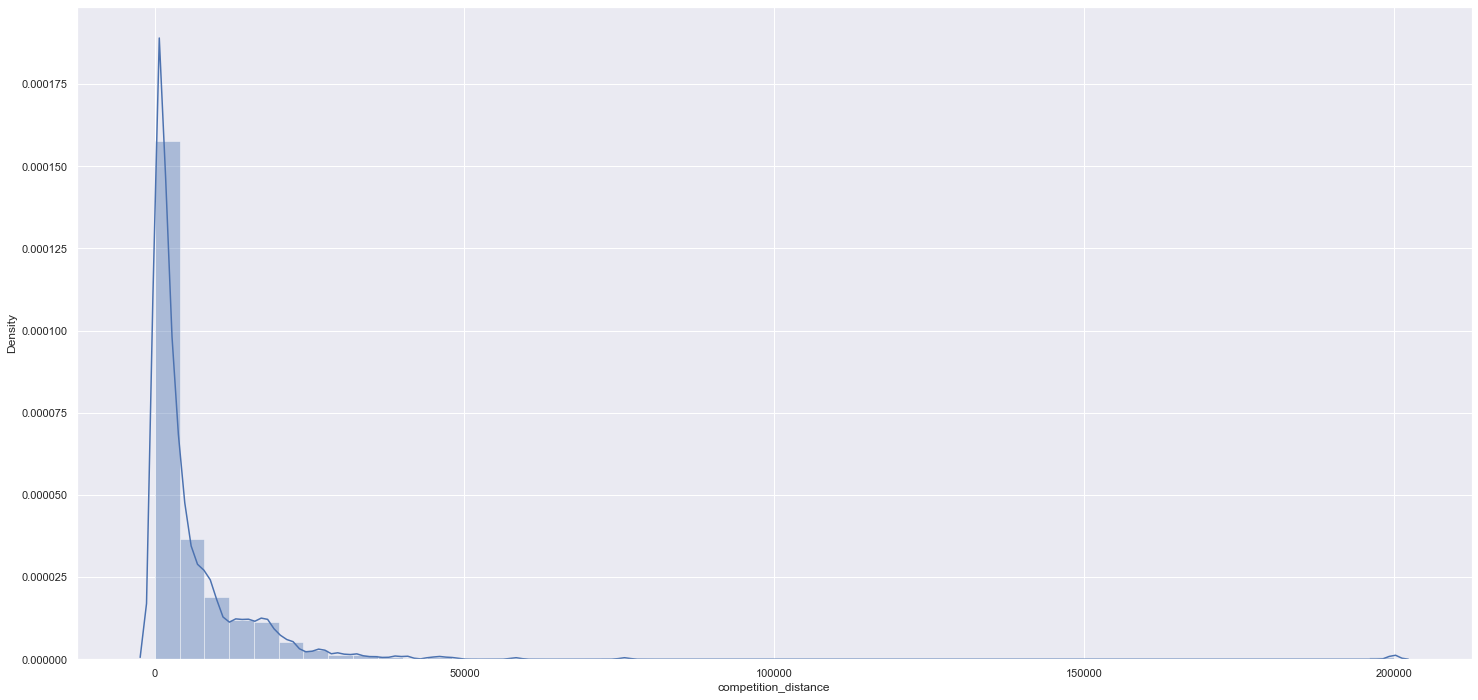

In [20]:
sns.distplot( df1["competition_distance"] )

### 1.7.2 Categorical Attribute

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )
#quantidade de tipos e cada categoria

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

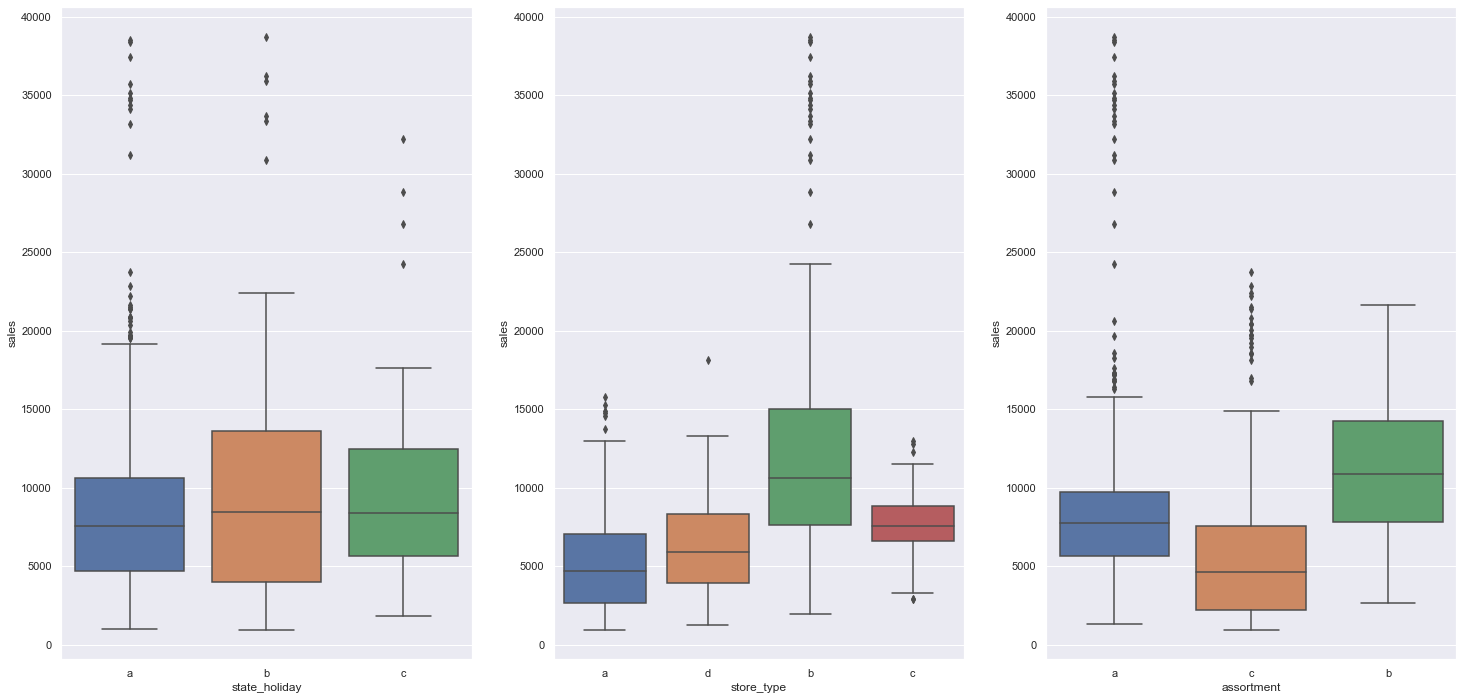

In [22]:
aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot( x= "state_holiday",y= "sales", data = aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x= "store_type",y= "sales", data = aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x= "assortment",y= "sales", data = aux1 )

# 2.0  FEATURE ENGINEERING

In [23]:
df2=df1.copy()

## 2.1 Mapa mental de Hipóteses

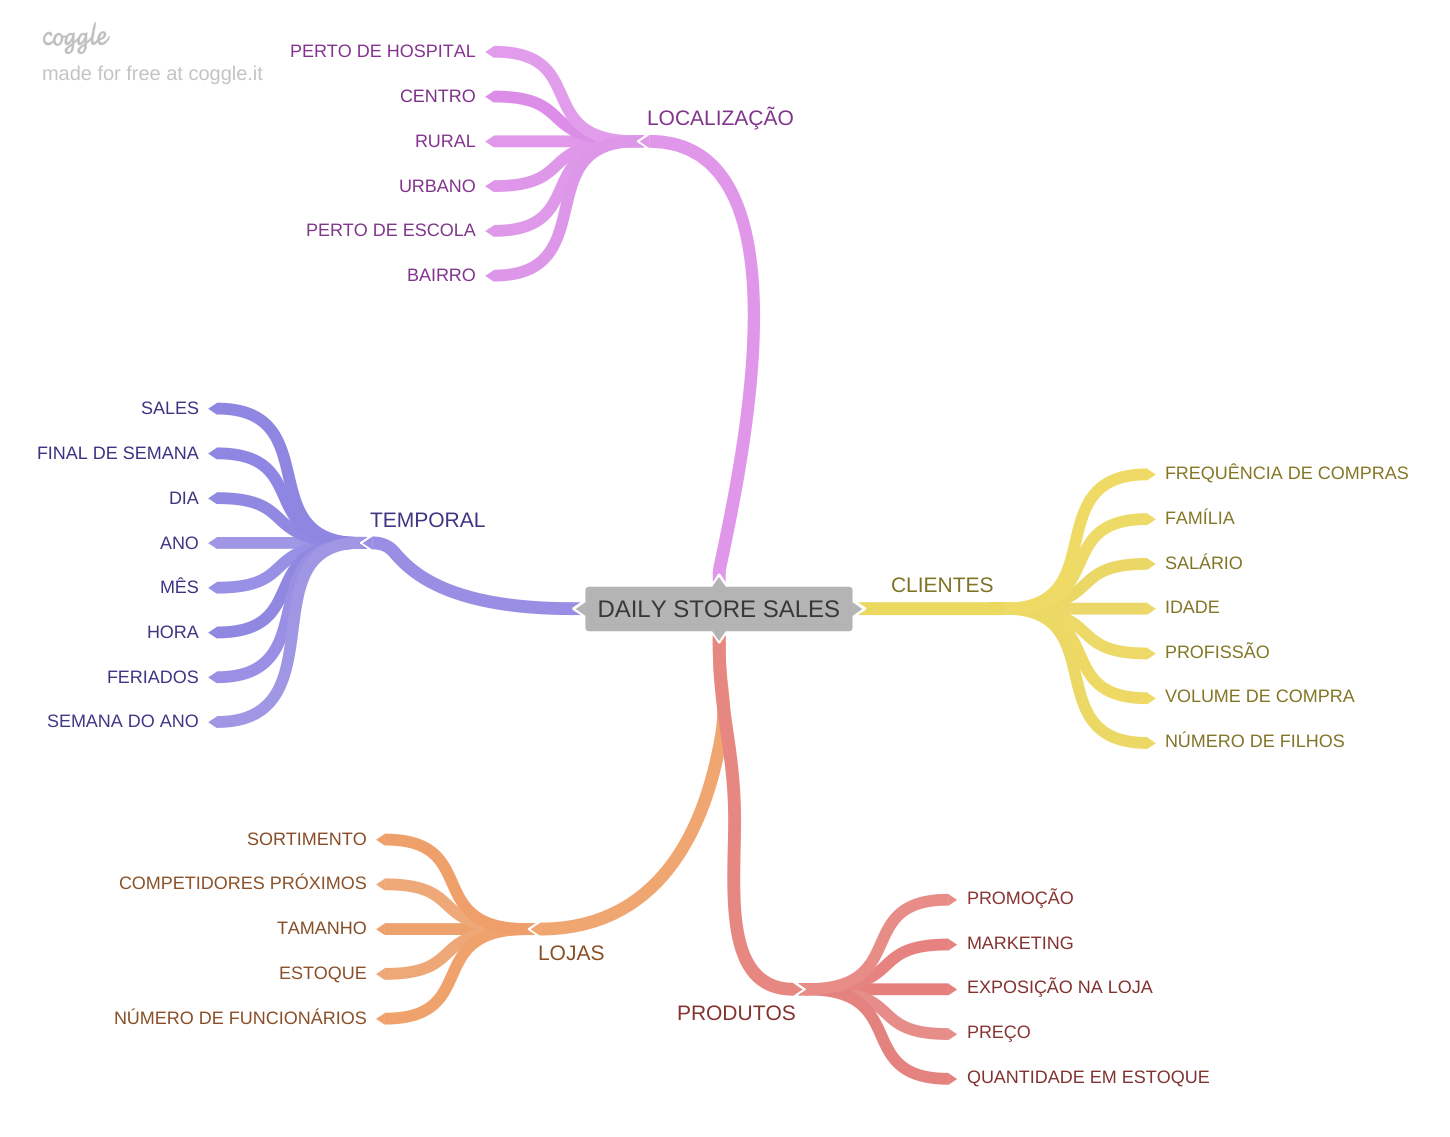

In [24]:
Image("img/MindMapHypothesis.png")

## 2.2 Criação de hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com competidores mais proximos deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Hipotese Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoe mais os produtos na vitrini deveriam vender mais

**3.** Lojas com preço menores deveriam vender mais

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**5.** Lojas com pormocoes mais agressivas deveriam vender mais

**6.** Lojas com mais dias de promocao deveriam vender mais

**7.** Lojas com mais promocoes consecutivas deveriam vender mais



### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas no natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre

**4.** Lojas deveriam vender mais a partir do dia 10 de cada mes

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante feriados escolares

## 2.3 Lista final de hipóteses

**1** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais



**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promocao deveriam vender mais

**6.** Lojas com mais promocoes consecutivas deveriam vender mais

**7.** Lojas abertas no natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre

**10.** Lojas deveriam vender mais a partir do dia 10 de cada mes

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante feriados escolares

## 2.4 Feature Engineering

In [25]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.weekofyear

# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")


# competition since
df2["competition_since"] = df2.apply (lambda x: datetime.datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis = 1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"])/30).apply(lambda x: x.days).astype("int64")

# promo since
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)

df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w") - datetime.timedelta(days=7))
                                              
df2["promo_time_week"] = ((df2['date'] - df2["promo_since"])/7).apply(lambda x: x.days).astype("int64")

# assortment
df2["assortment"] = df2["assortment"].apply( lambda x: "basic" if x=='a' else "extra" if x=='b' else "extended")


# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday"  if x=='a' else "easter_holiday" if x=='b' else "christmas" if x=='c' else "regular_day") 



In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [29]:
df3 = df3[(df3 ["open"] != 0) & (df3["sales"] > 0)]

## 3.2 selecao das colunas

In [30]:
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop(cols_drop, axis=1)
#customers nao teremos no momento da previsao, logo nao ajudaria 
#open agora q excluímos a opcao 0 sempre sera 1, nao ajudaria na analise
# promo_interval e month_map nao precisamos mais devido as novas colunas criadas na etapa de feature eng

# 4.0 ANALISE EXPLORATORIA DOS DADOS

In [31]:
df4 = df3.copy()

In [32]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Analise Univarida

### 4.1.1 Response variable

<AxesSubplot:xlabel='sales'>

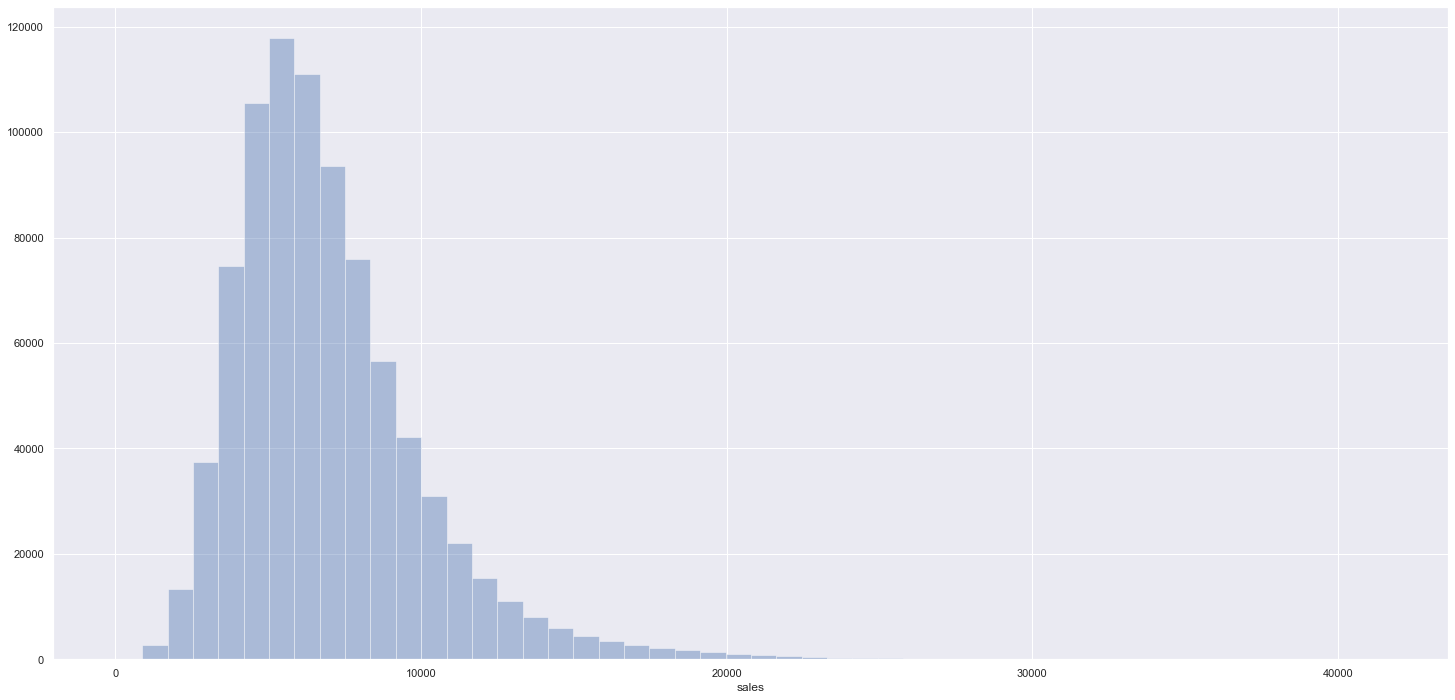

In [33]:
sns.distplot(df4["sales"], kde = False)

### 4.1.2 Numerical variable

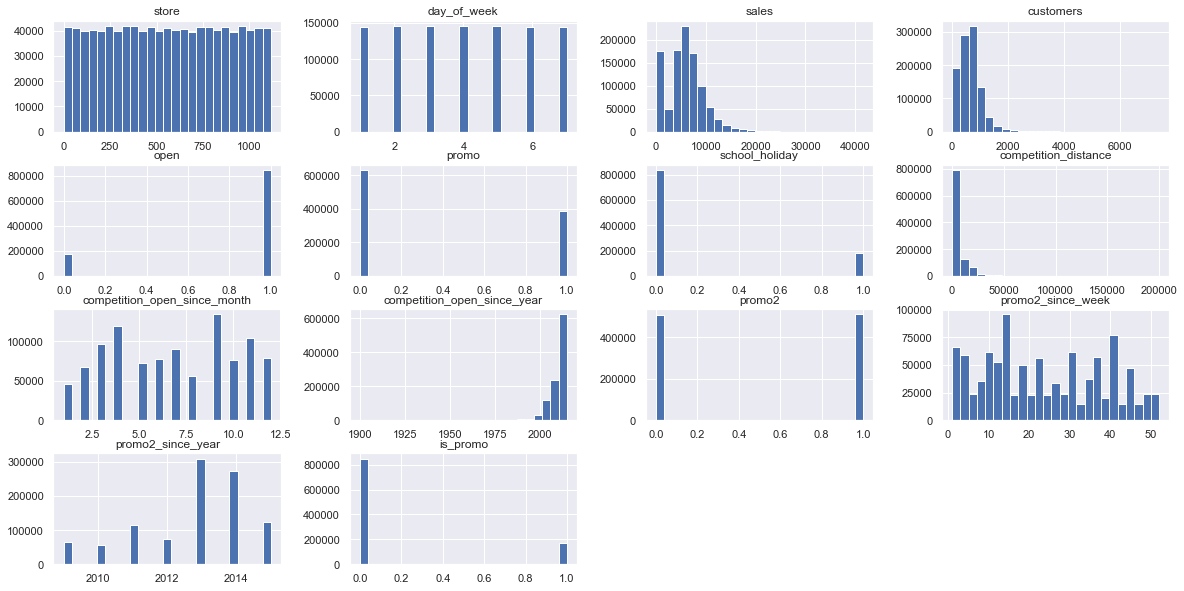

In [34]:
num_attributes.hist( bins=25 , figsize = (20,10));


### 4.1.3 Categorical Variable

In [35]:
df4["assortment"].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

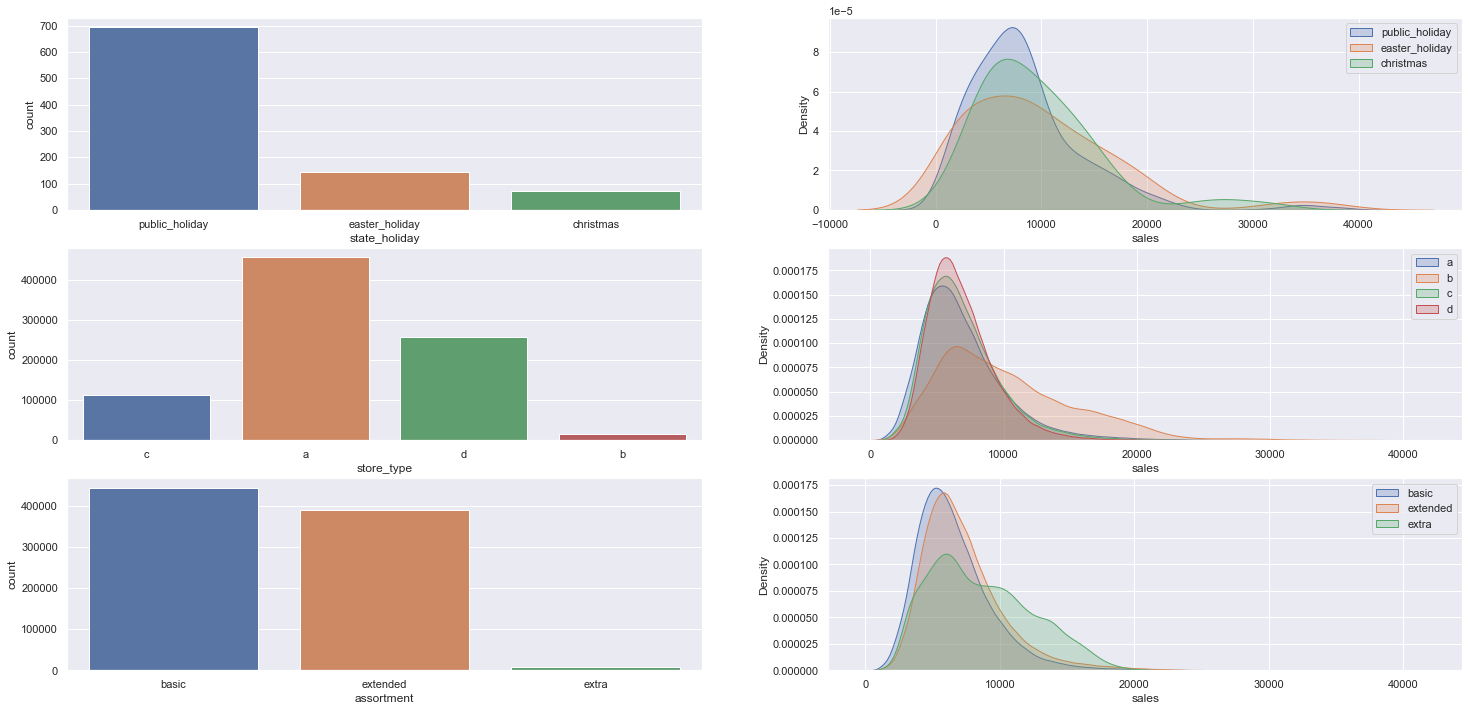

In [36]:
#state_holiday: qual tipo de feriado impacta mais
plt.subplot(3,2,1)
a = df4[df4["state_holiday"] != "regular_day" ]
sns.countplot( a["state_holiday"] )


plt.subplot(3,2,2)
sns.kdeplot( df4[df4["state_holiday"] == "public_holiday"]["sales"], label = "public_holiday", shade = True)
sns.kdeplot( df4[df4["state_holiday"] == "easter_holiday"]["sales"], label = "easter_holiday", shade = True)
sns.kdeplot( df4[df4["state_holiday"] == "christmas"]["sales"], label = "christmas", shade = True)
plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot( df4["store_type"] )

plt.subplot(3,2,4)
sns.kdeplot( df4[df4["store_type"] == "a"]["sales"], label = "a", shade = True)
sns.kdeplot( df4[df4["store_type"] == "b"]["sales"], label = "b", shade = True)
sns.kdeplot( df4[df4["store_type"] == "c"]["sales"], label = "c", shade = True)
sns.kdeplot( df4[df4["store_type"] == "d"]["sales"], label = "d", shade = True)
plt.legend()

#assortment	
plt.subplot(3,2,5)
sns.countplot( df4["assortment"] )

plt.subplot(3,2,6)
sns.kdeplot( df4[df4["assortment"] == "basic"]["sales"], label = "basic", shade = True)
sns.kdeplot( df4[df4["assortment"] == "extended"]["sales"], label = "extended", shade = True)
sns.kdeplot( df4[df4["assortment"] == "extra"]["sales"], label = "extra", shade = True)
plt.legend()

## 4.2 Analise Bivarida

### H1. Lojas com maior sortimento deveriam vender mais

**FALSA** Lojas com MAIOR sortimento vendem MENOS 

<AxesSubplot:xlabel='year_week'>

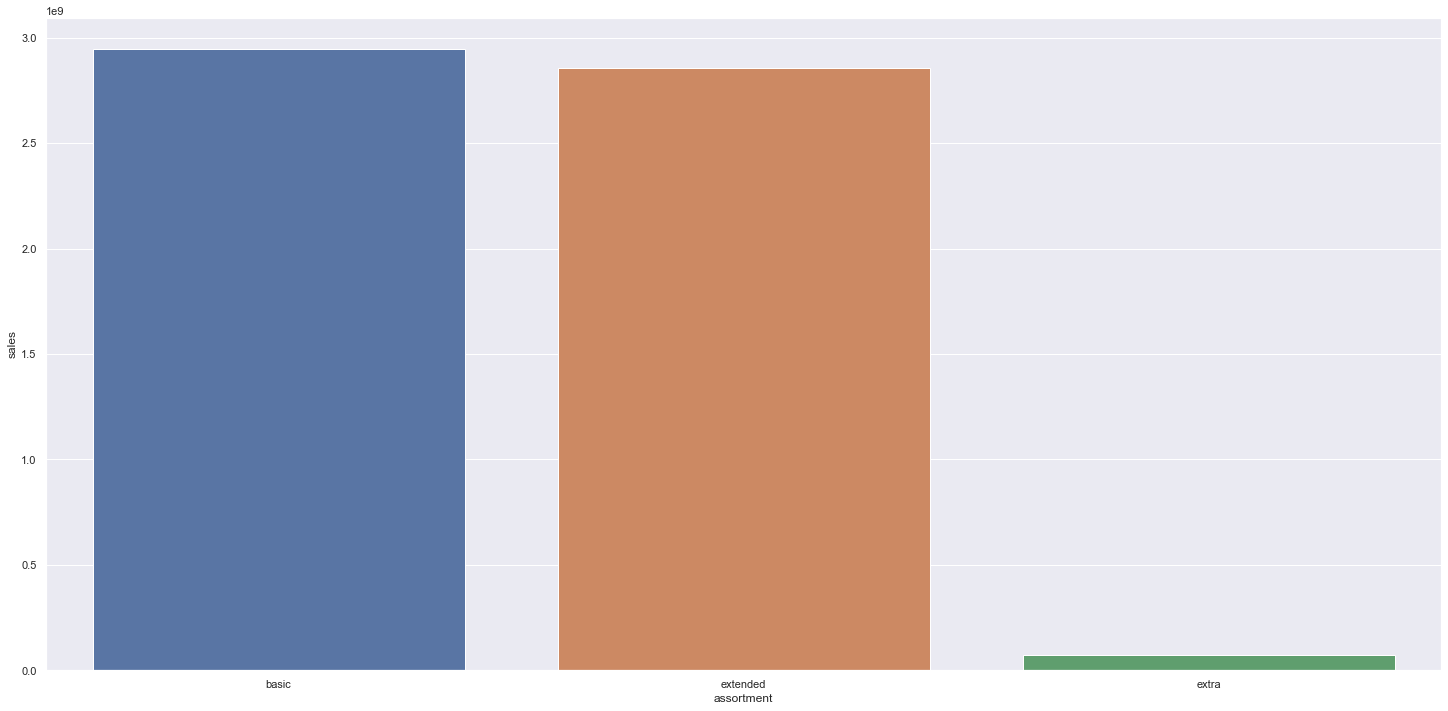

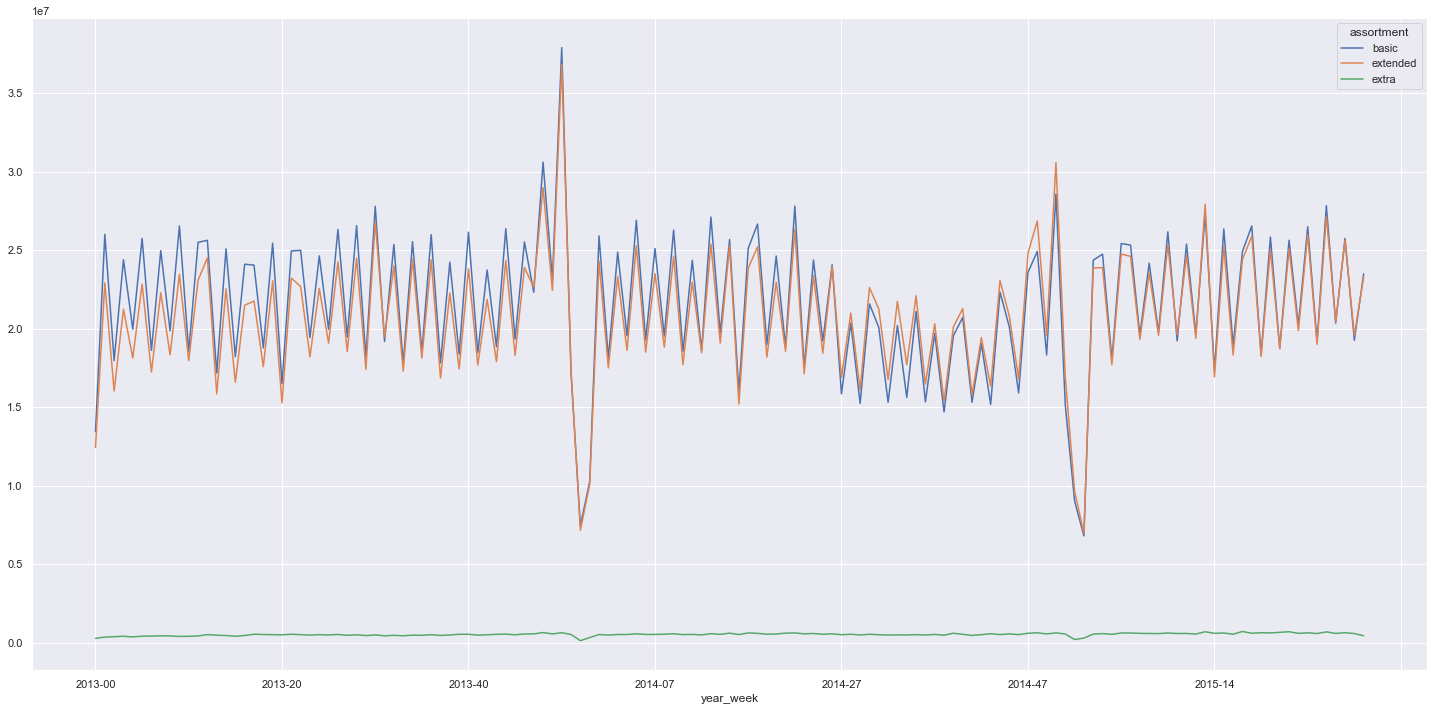

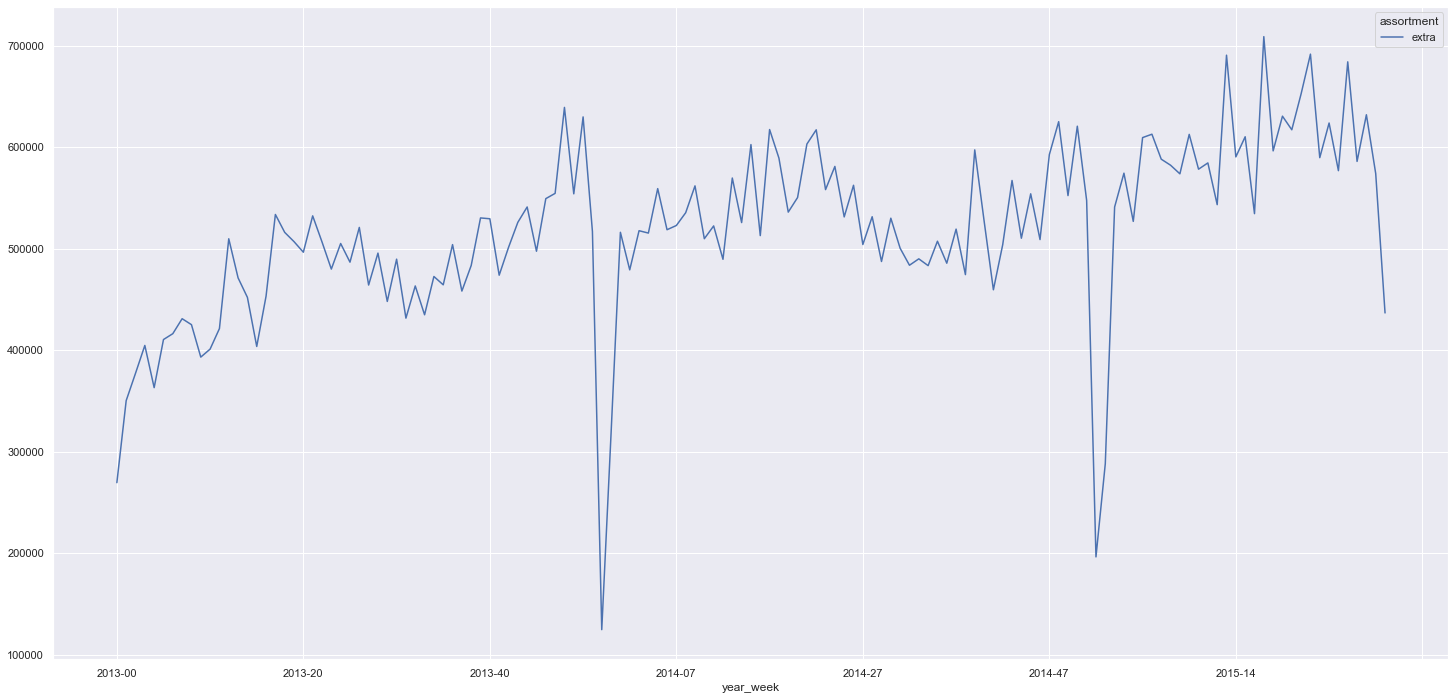

In [37]:
aux1 = df4[["assortment","sales"]].groupby("assortment").sum().reset_index()
sns.barplot(x= "assortment", y = "sales", data = aux1);


aux2 = df4[["year_week", "assortment","sales"]].groupby(["year_week", "assortment"]).sum().reset_index()
aux2.pivot( index="year_week", columns="assortment", values="sales" ).plot()

aux3 = aux2[aux2["assortment"] == "extra"]
aux3.pivot( index="year_week", columns="assortment", values="sales" ).plot()


### H2. Lojas com competidores mais proximos deveriam vender menos
**FALSA** Lojas com competidores MAIS PROXIMOS vemdem MAIS





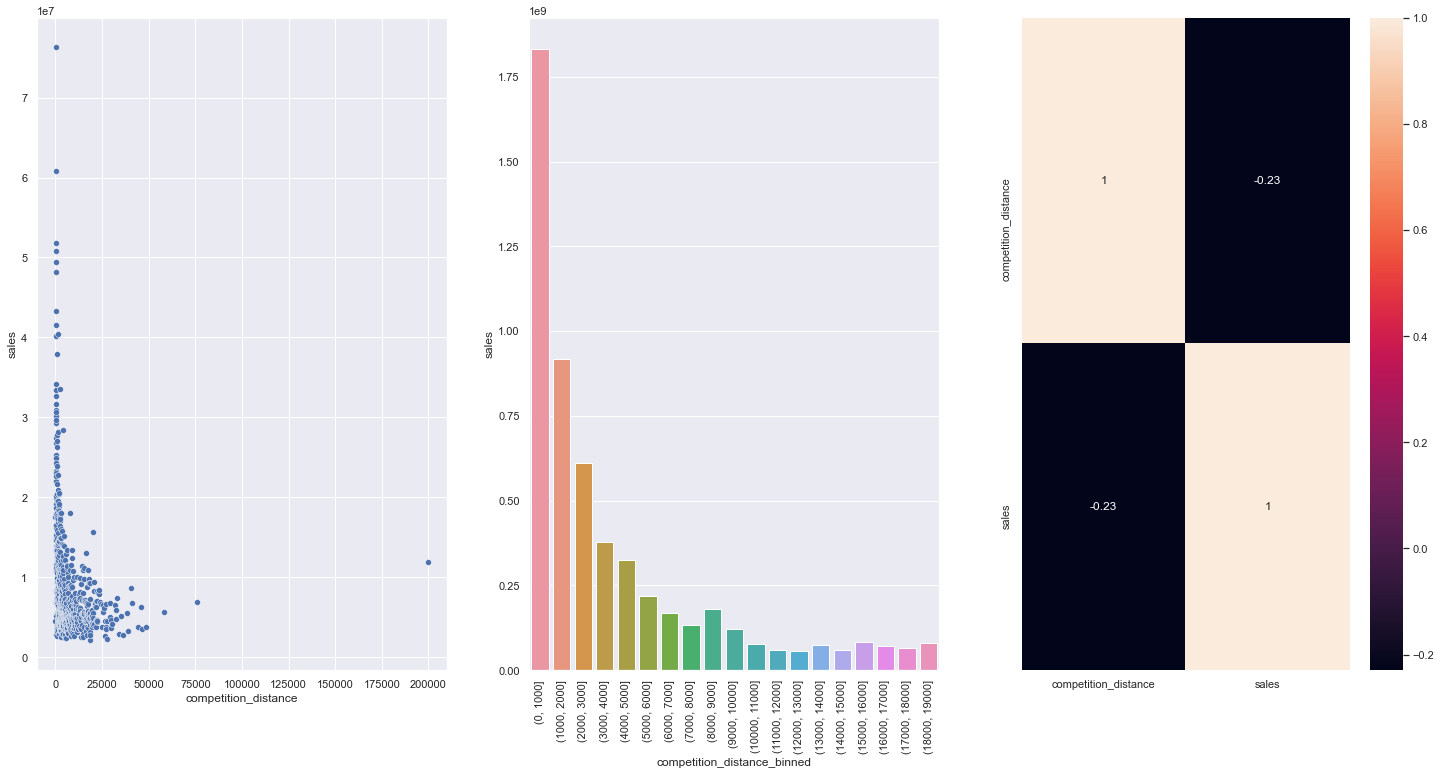

In [38]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index() 

plt.subplot(1,3,1)
sns.scatterplot(x="competition_distance", y="sales", data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1["competition_distance_binned"] = pd.cut( aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index() 
sns.barplot(x= "competition_distance_binned", y="sales", data=aux2);
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True);

### H3. Lojas com competidores a mais tempo deveriam vender mais
**FALSA** Lojas com competidores a MAIS TEMPO vendem MENOS


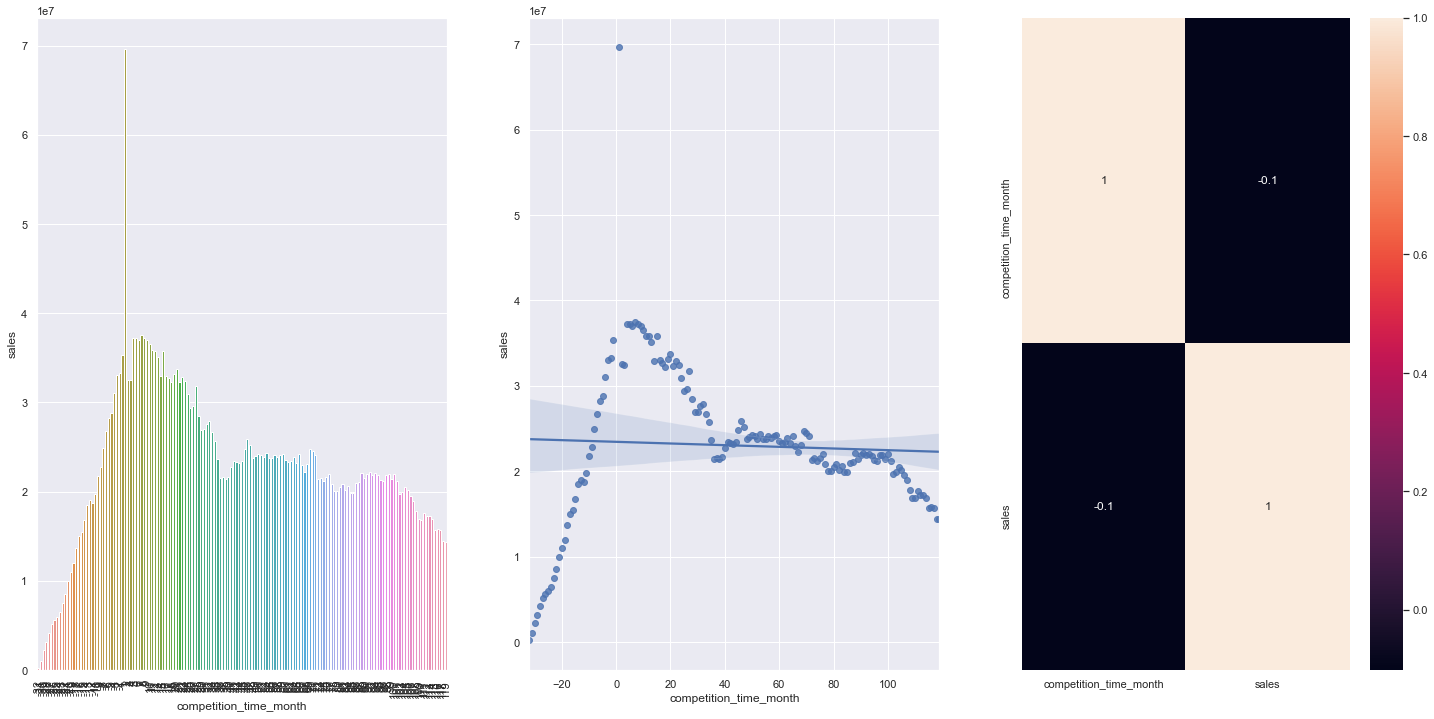

In [39]:
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").sum().reset_index()
aux2 = aux1[(aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0)]
plt.subplot(1,3,1)
sns.barplot(x="competition_time_month", y="sales", data= aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x="competition_time_month", y="sales", data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True);

### **H4.** Lojas com promocoes ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promocoes ativas por MAIS tempo vendem MENOS, depois de um certo periodo de promocao



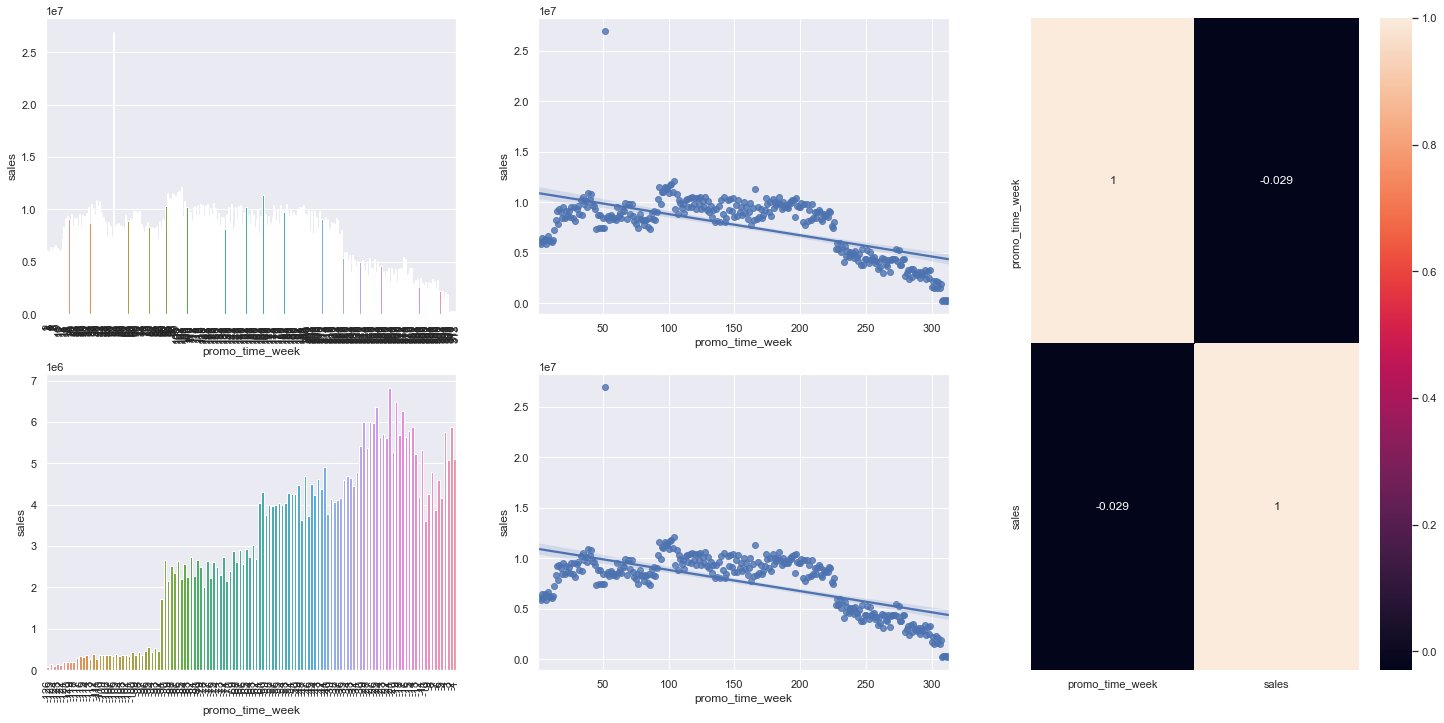

In [40]:
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1["promo_time_week"] > 0] #periodo de promo extendido
sns.barplot(x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1["promo_time_week"] < 0] #periodo de promo regular
sns.barplot(x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method = "pearson"), annot = True);


### <s> **H5.** Lojas com mais dias de promocao deveriam vender mais </s>



### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais
**FALSA** Lojas com MAIS promocoes consecutivas vendem MENOS

In [41]:
df4[["promo", "promo2","sales"]].groupby(["promo","promo2"]).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


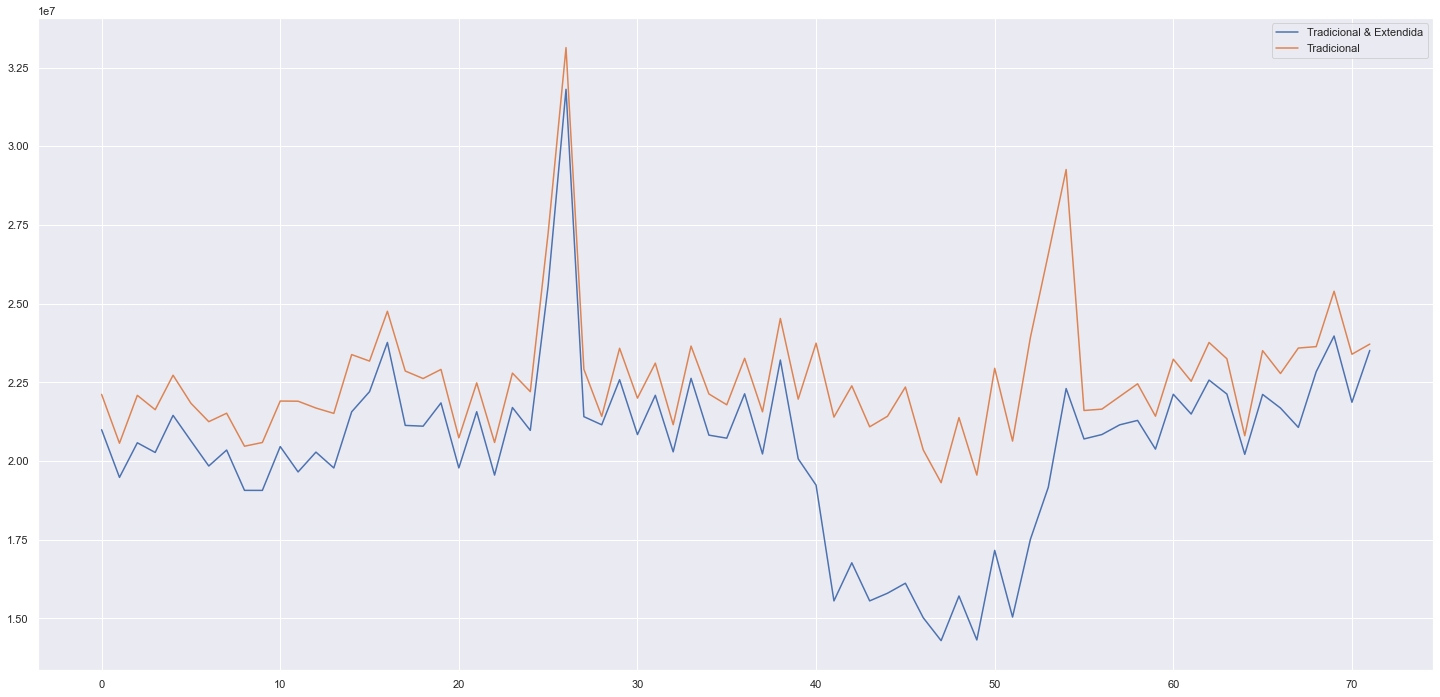

In [42]:
aux1 = df4[(df4["promo"] == 1) & (df4["promo2"] == 1)][["year_week","sales"]].groupby("year_week").sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4["promo"] == 1) & (df4["promo2"] == 0)][["year_week","sales"]].groupby("year_week").sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels = ["Tradicional & Extendida", "Tradicional"]);

### **H7.** Lojas abertas no natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado do natal vendem MENOS


<AxesSubplot:xlabel='year', ylabel='sales'>

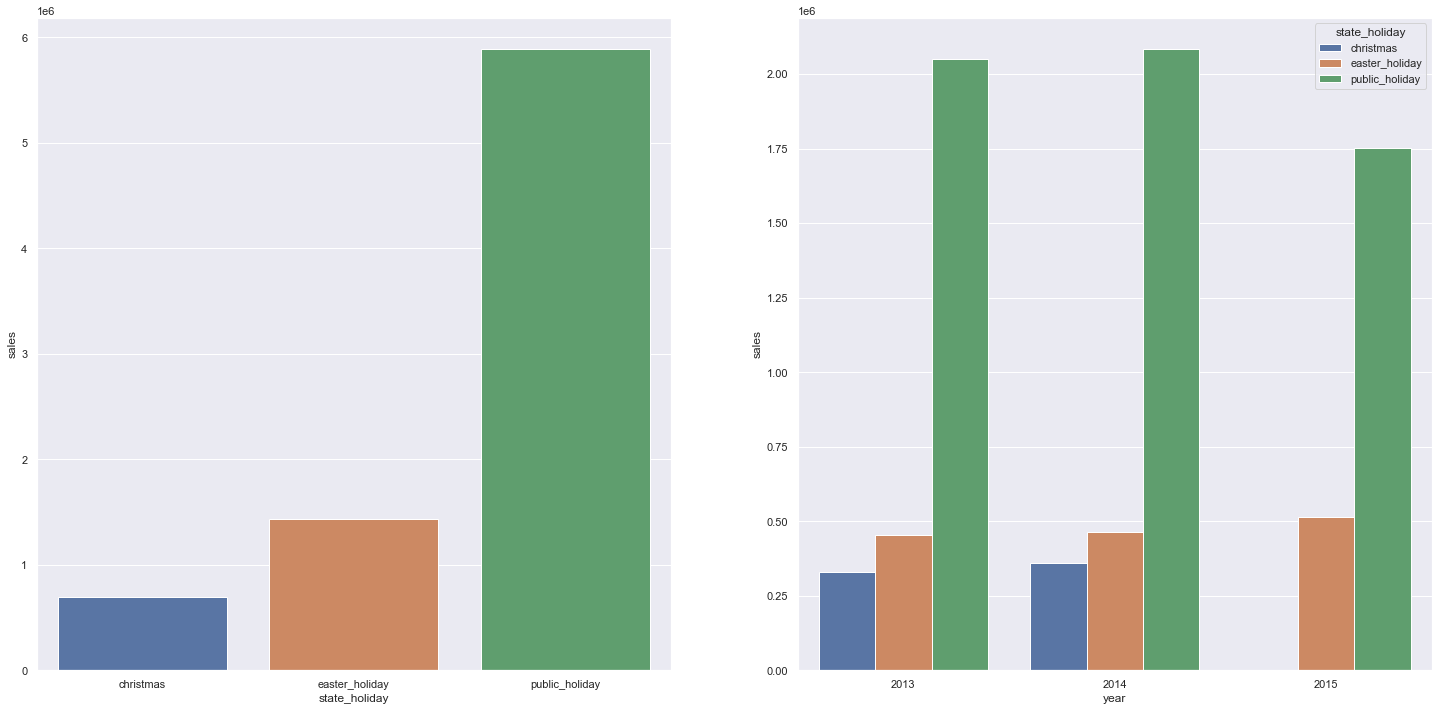

In [43]:
aux = df4[df4["state_holiday"] != "regular_day"]
plt.subplot(1,2,1)
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x= "state_holiday", y="sales", data=aux1);

plt.subplot(1,2,2)
aux2 = aux[["year","state_holiday","sales"]].groupby(["year", "state_holiday"]).sum().reset_index()
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2)

### **H8.** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem MENOS ao longo dos anos


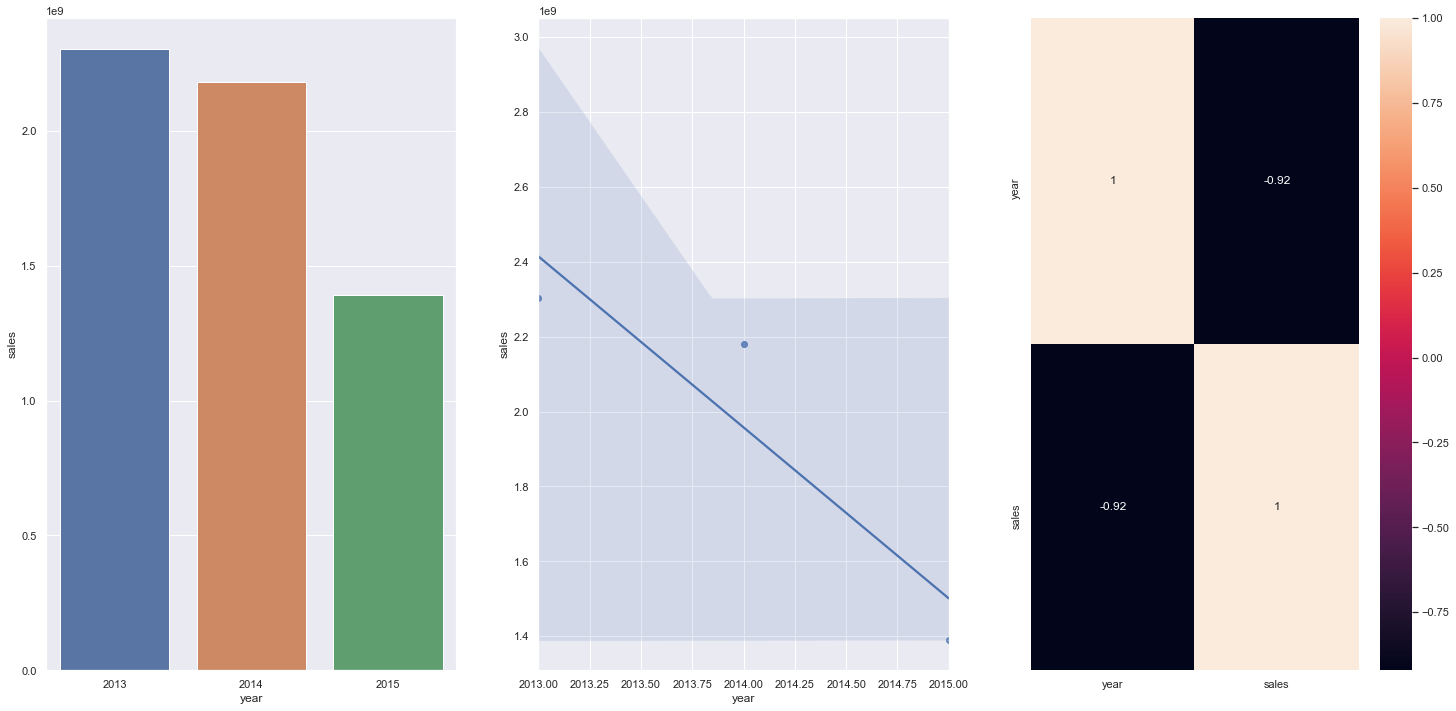

In [44]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method = "pearson"), annot = True);


### **H9.** Lojas deveriam vender mais no segundo semestre
**FALSA** Lojas vendem MENOS no segundo semestre do ano


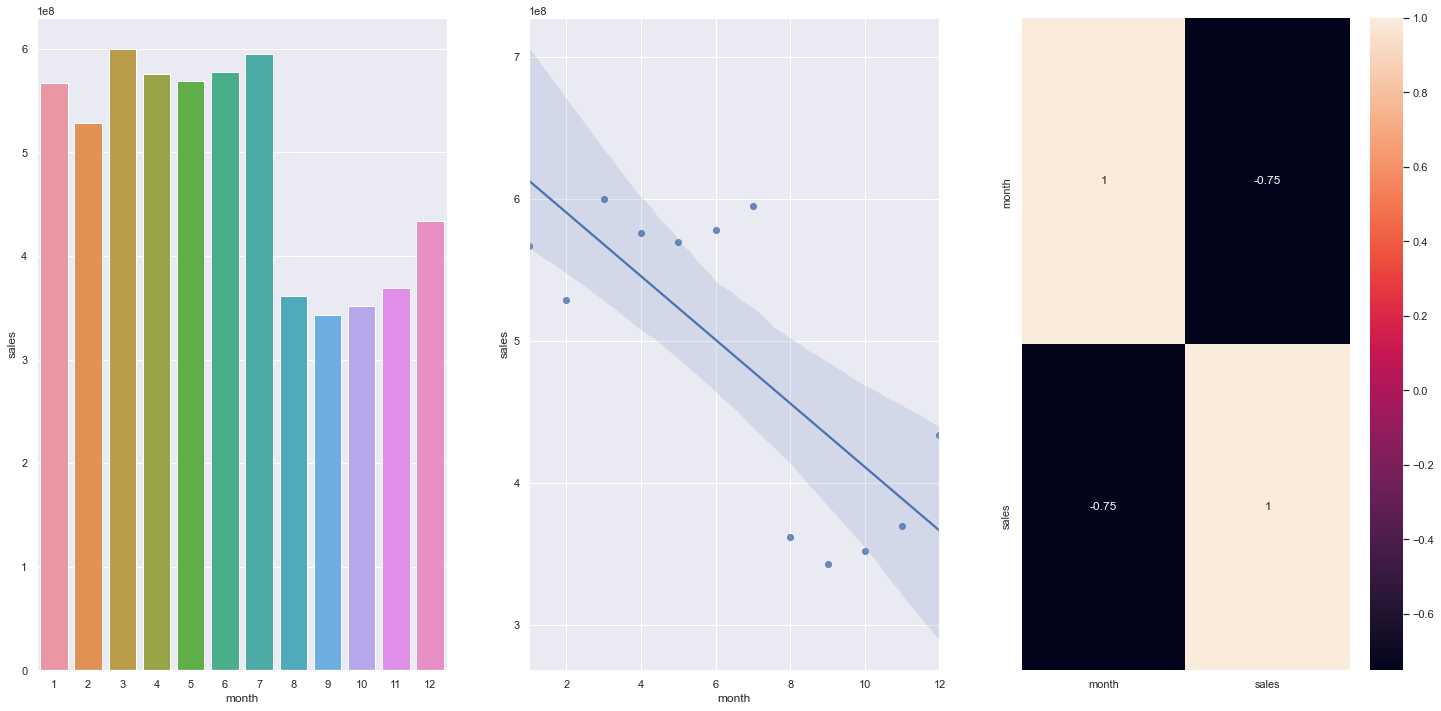

In [45]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot = True);

### **H10.** Lojas deveriam vender mais a partir do dia 10 de cada mes
**FALSO** o comportamento e muito parecido durante o mes com tendência de queda


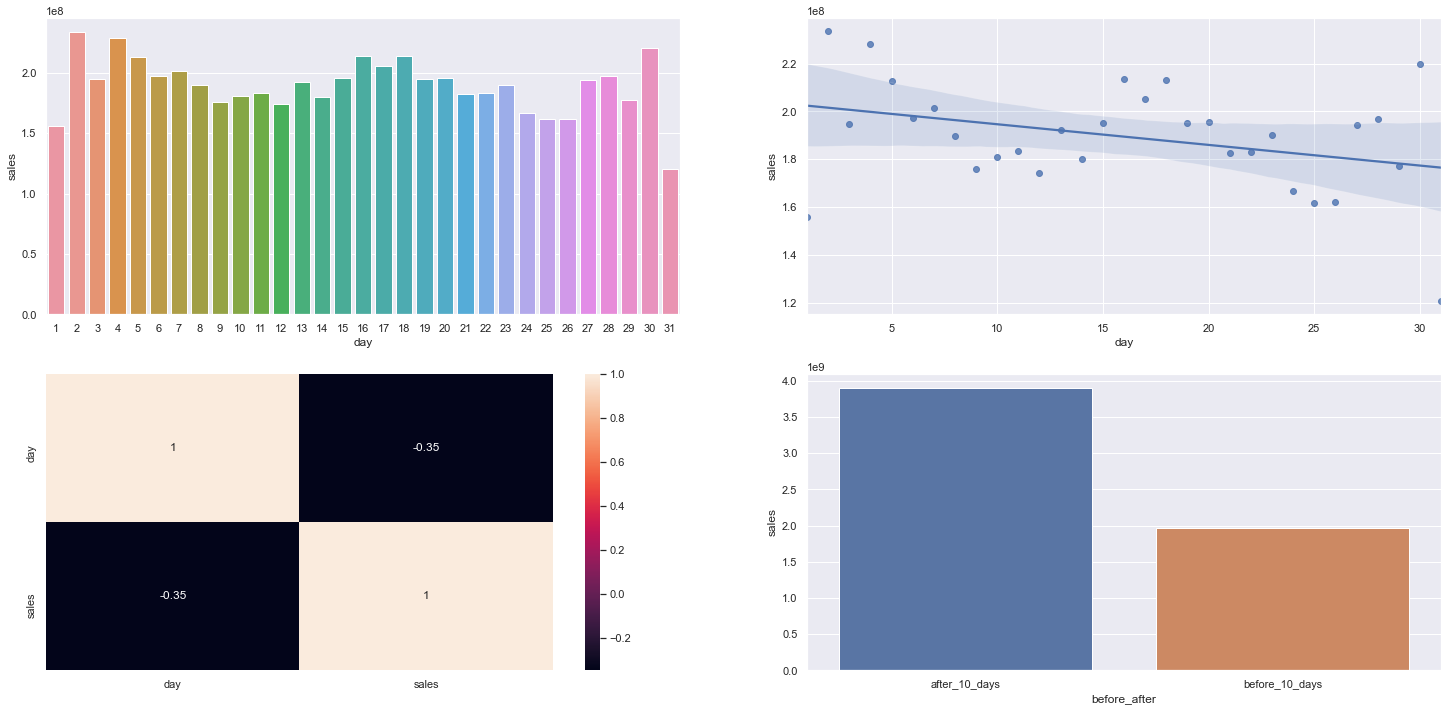

In [46]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = "pearson"), annot = True);

plt.subplot(2,2,4)
aux1["before_after"] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', "sales"]].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem MENOS nos finais de semana


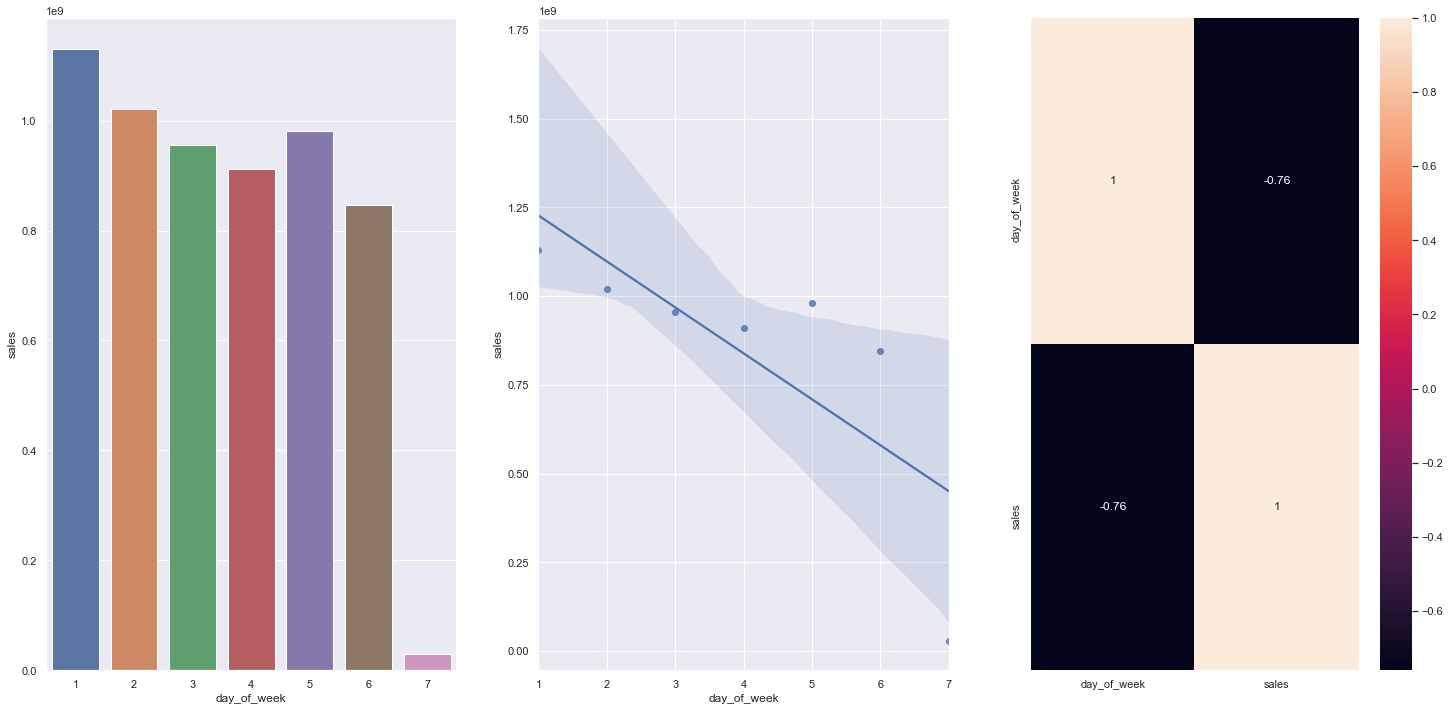

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot = True);

### **H12.** Lojas deveriam vender menos durante feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares exceto meses de julho e agosto

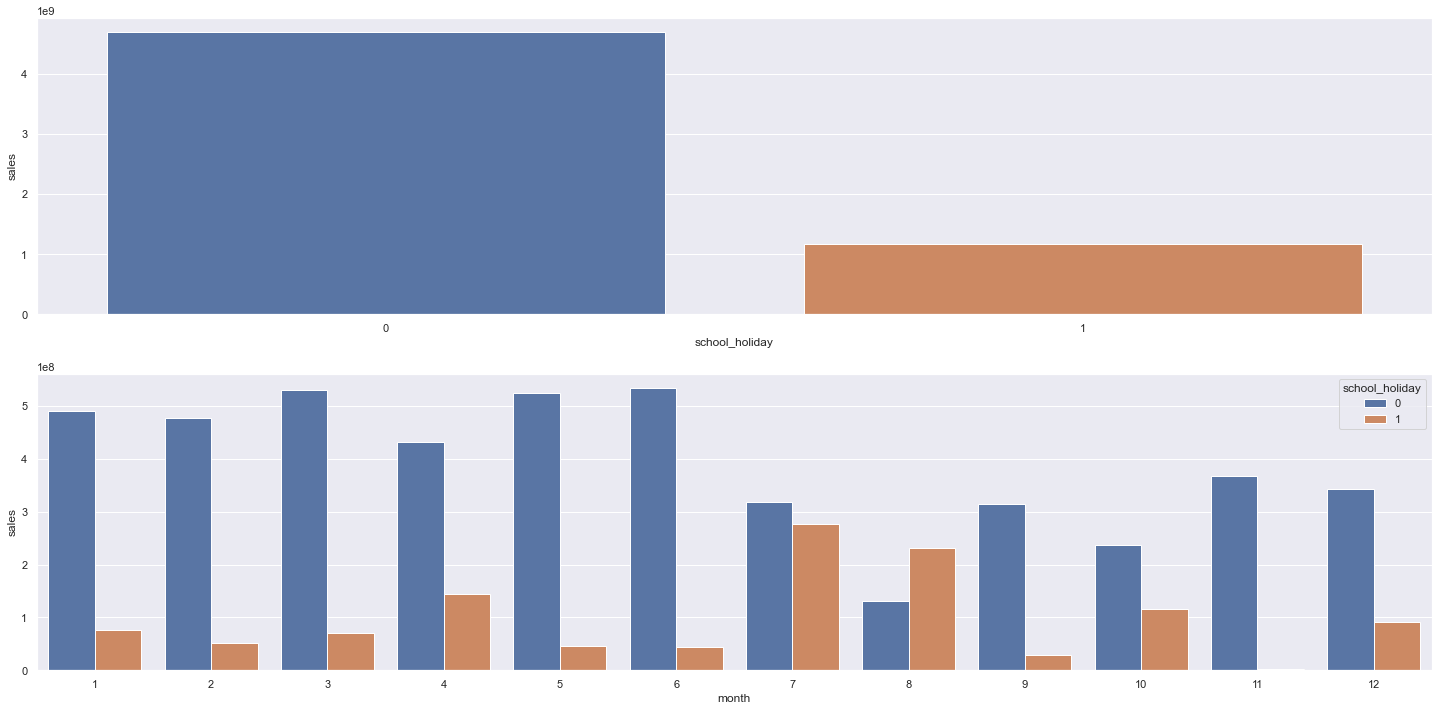

In [48]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);



### 4.2.1. Resumo das Hipoteses

In [49]:
tab = [["Hipotese", "Conclusao", "Relevancia"],
      ["H1", "Falsa","Baixa"],
      ["H2", "Falsa","Media"],
      ["H3", "Falsa","Media"],
      ["H4", "Falsa","Baixa"],
      ["H5", "-","-"],
      ["H6", "Falsa","Baixa"],
      ["H7", "Falsa","Media"],
      ["H8", "Falsa","Alta"],
      ["H9", "Falsa","Alta"],
      ["H10", "Falsa","Alta"],
      ["H11", "Falsa","Alta"],
      ["H12", "Falsa","Baixa"],
      ]
tabela_de_relevancia = tabulate(tab, headers= 'firstrow' )
print( tabela_de_relevancia )

Hipotese    Conclusao    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Falsa        Alta
H10         Falsa        Alta
H11         Falsa        Alta
H12         Falsa        Baixa


## 4.3 Analise Multivarida

### 4.3.1 Numerical Attributes

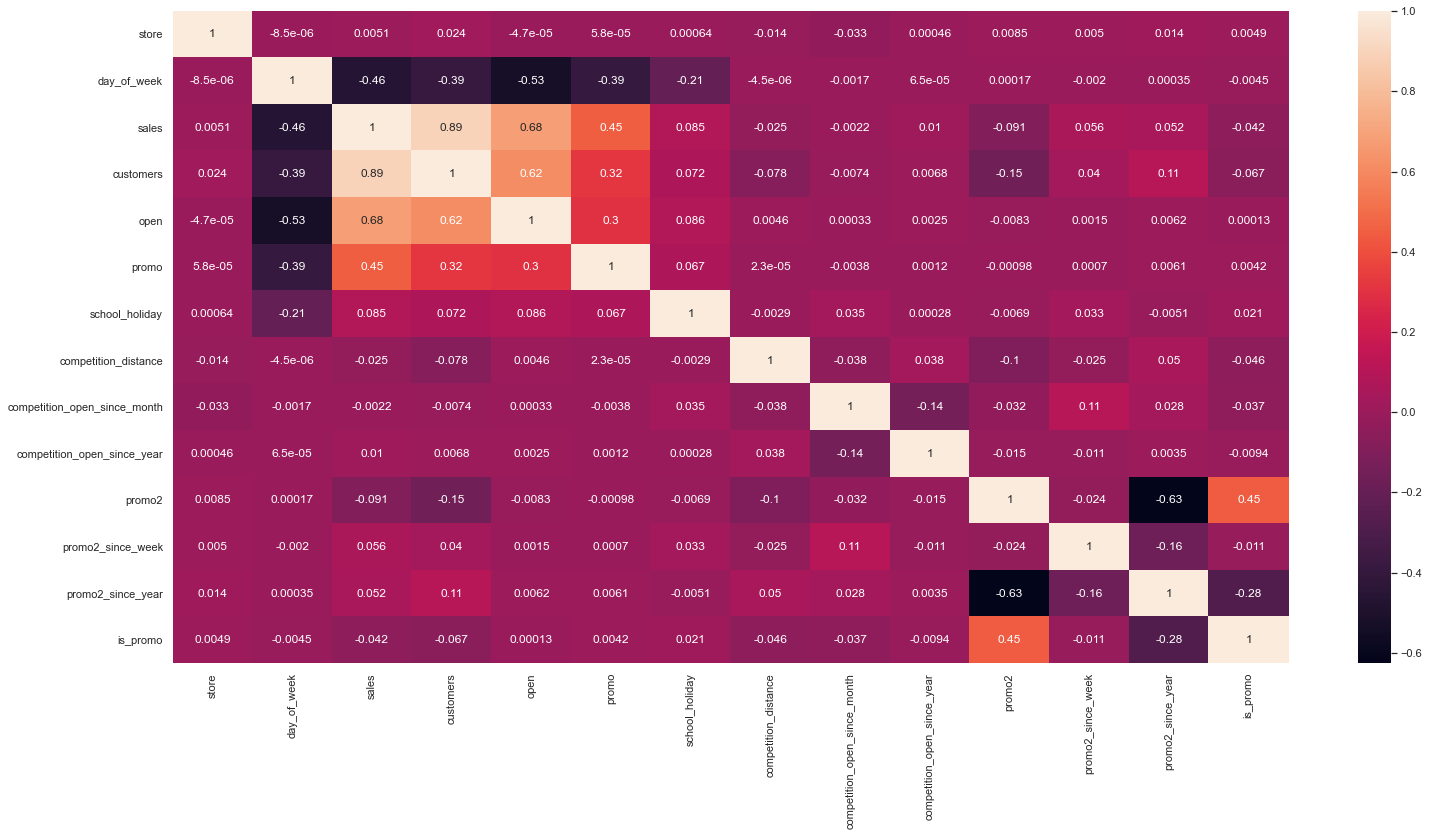

In [50]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2 Categorical Attributes

In [51]:
#only cattegorical data
a = df4.select_dtypes(include = 'object')

#calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#final dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
             'store_type':[a4, a5, a6],
             'assortment':[a7, a8, a9] })

d = d.set_index(d.columns)

d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

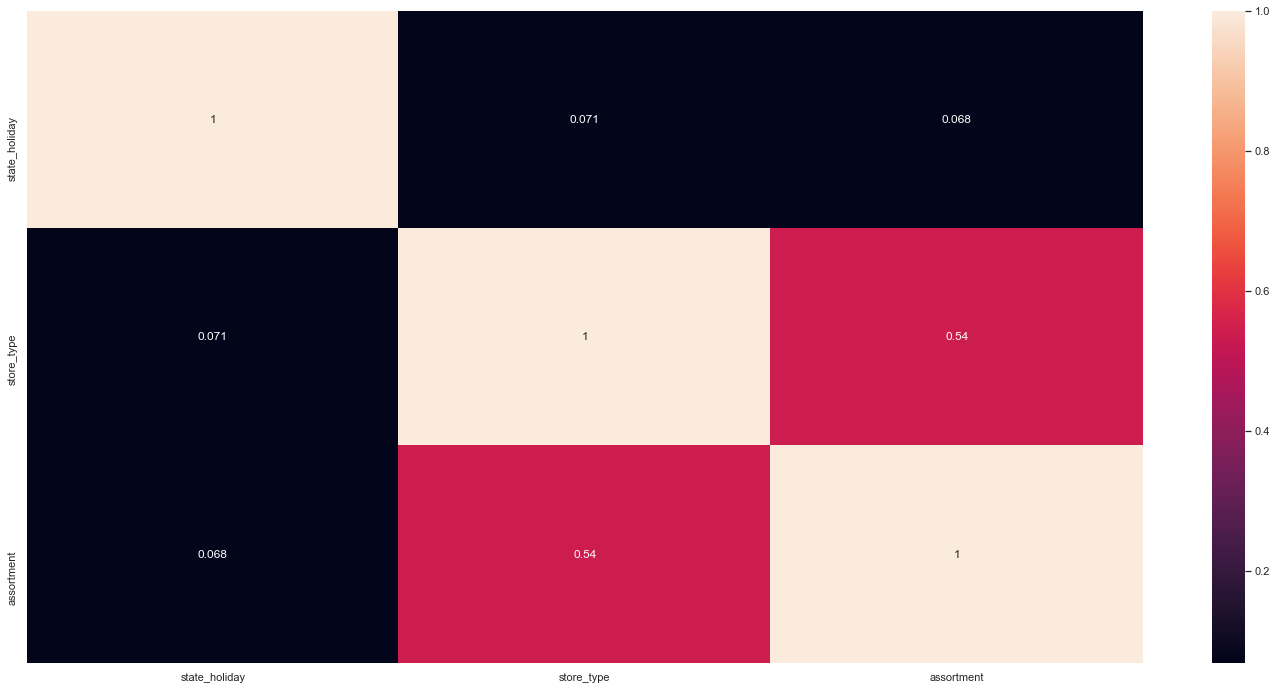

In [52]:
sns.heatmap(d, annot = True)

# 5.0 DATA PREPARATION

In [53]:
df5 = df4.copy()

## 5.1 Normalização

In [54]:
# não temos variaveis com comportamentos de distribuicao gaussiana

## 5.2 Rescaling

In [55]:
a = df5.select_dtypes(include = ["int64", "float64"])

<AxesSubplot:xlabel='promo_time_week'>

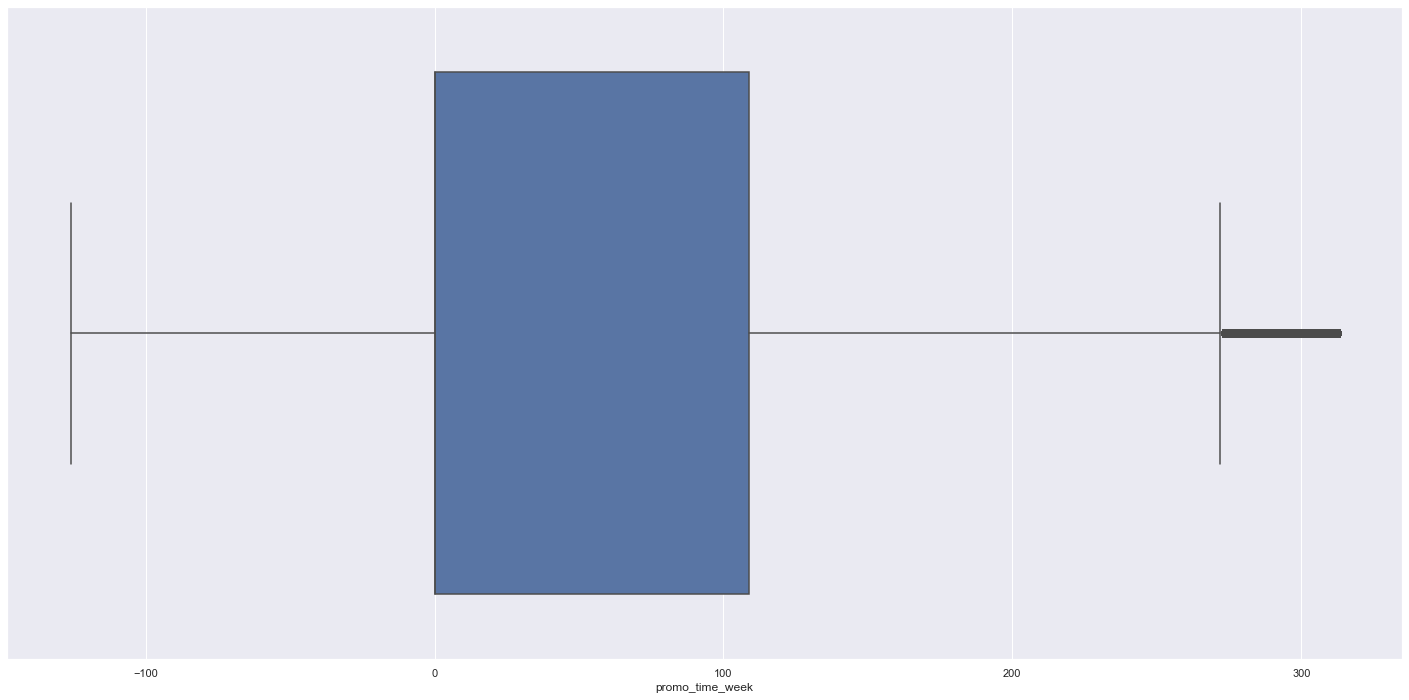

In [56]:
sns.boxplot( df5['promo_time_week']) #analisar para ver se há outliers e assim decidir o metodo (min-max ou robust scaler)

In [57]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))


#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))


#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))



## 5.3 Transformação

### 5.3.1 Encoding

In [58]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment - Ordinal Encoding
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [59]:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot:xlabel='sales', ylabel='Density'>

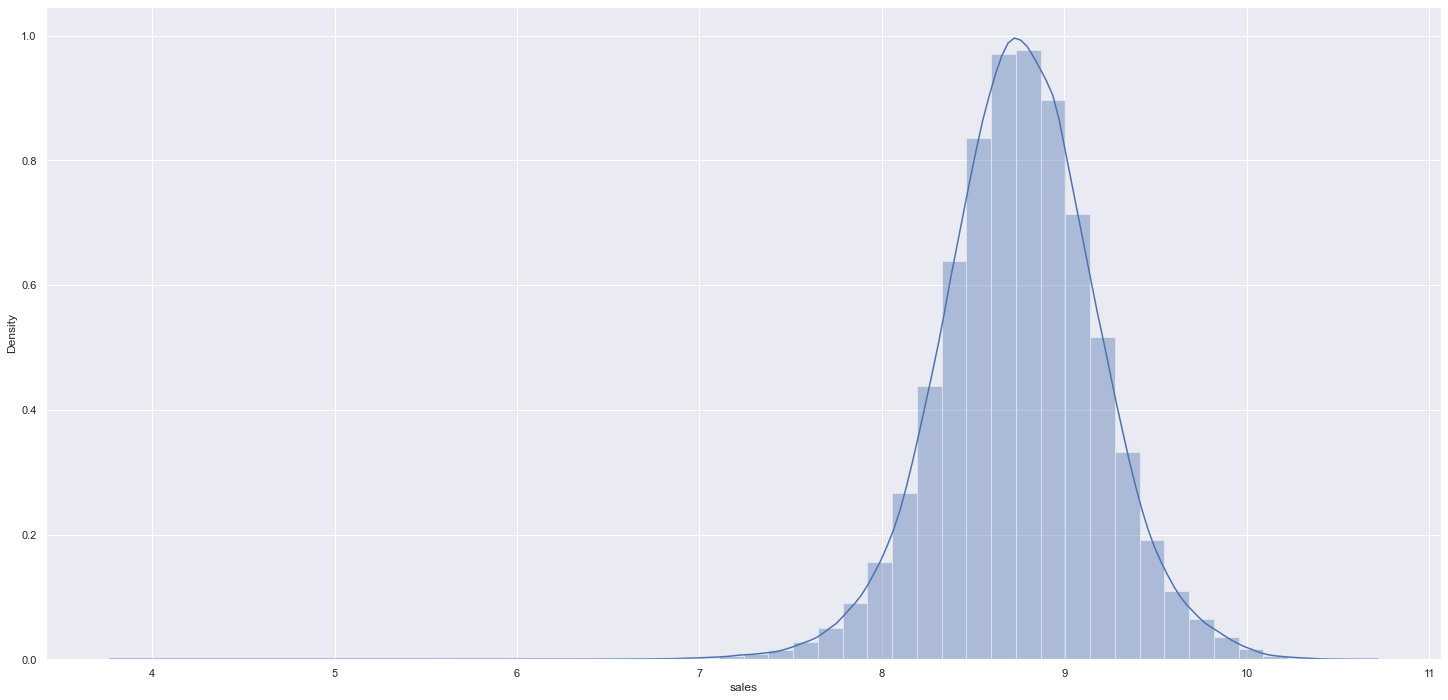

In [60]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [61]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))


In [62]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 SELECAO DE VARIAVEIS

In [63]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [64]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [65]:
# como os nossos dados sao temporais, nao iremos escolher os conjuntos de teste e treino aleatoriamente
# escolhemos entao separar as ultimas 6 semanas de dados como sendo os dados de teste


In [66]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [67]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [68]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print ('Training Min Date: {}'.format(x_train['date'].min()))
print ('Training Max Date: {}'.format(x_train['date'].max()))

print ('\nTest Min Date: {}'.format(x_test['date'].min()))
print ('Test Min Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [69]:
# training and test dataset for Boruta
x_train_n = x_train.drop(['date','sales'], axis = 1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1 )


## define Boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit(x_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [70]:
#cols_selected = boruta.support_.tolist()

## best features
#x_train_fs = x_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

##not selected Boruta
#cols_not_selected_boruta = list (np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [71]:
#cols_selected_boruta

In [72]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',                       
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [73]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# 7.0 MACHINE LEARNING MODELING

In [74]:
df7 = df6.copy()

In [75]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

#Time series Data Preparation
X_training = x_train[cols_selected_boruta_full]

## 7.1 Avarege Model

In [76]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

#predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Avarege Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarege Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [77]:
#model
lr =LinearRegression().fit(X_train, y_train)

#prediction
yhat_lr = lr.predict(X_test)

##performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [78]:
#lr_result_cv = cross_validation (X_training, 5, 'Linear Regression', lr, verbose = False)
#lr_result_cv

## 7.3 Linear Regression Regularized Model - Lasso

In [79]:
#model
lrr =Lasso(alpha = 0.01).fit(X_train, y_train)

#prediction
yhat_lrr = lrr.predict(X_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [80]:
#lrr_result_cv = cross_validation (X_training, 5, 'Lasso', lrr, verbose = False)
#lrr_result_cv

## 7.4 Random Forest Regressor

In [81]:
##model
#rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(X_train, y_train)

##prediction
#yhat_rf = rf.predict(X_test)

##performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

###  7.4.1 Random Forest Regressor - Cross Validation

In [82]:
#rf_result_cv = cross_validation (X_training, 5, 'Random Forest Regressor', rf, verbose = True)
#rf_result_cv

## 7.5 XGBoost Regressor

In [83]:
##model
#model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                             n_estimators = 100,
#                             eta = 0.01,
#                             max_depth = 10,
#                             subsample = 0.7,
#                             colsample_bytree = 0.9).fit(X_train, y_train)

##prediction
#yhat_xgb = model_xgb.predict(X_test)

##performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [84]:
#xgb_result_cv = cross_validation (X_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
#xgb_result_cv

## 7.6 Compare Model's Performace

### 7.6.1 Single Performance

In [85]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [86]:
#modelling_result_cv = pd.concat([ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv

# 8.0 HYPERPARAMETER FINE TUNING 

In [87]:
df8 = df7.copy()

## 8.1 Random Search

In [88]:
param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
         'eta':[0.01, 0.03],
         'max_depth':[3, 5, 9],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15]}

MAX_EVAL = 10

In [89]:
#final_result = pd.DataFrame()
#for i in range (MAX_EVAL):
    #choose values for parameters randomly
#    hp = { k : random.sample( v, 1 )[0] for k,v in param.items() }
#    print (hp)
    
    #model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight'])

    #performance
#    result = cross_validation(X_training, 5, 'XGBoost Regressor', model_xgb, verbose = False)
#    final_result = pd.concat([final_result, result])
    
#final_result

## 8.2 Final Model

In [90]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 }


In [91]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(X_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,769.069758,0.115473,1102.545076


In [92]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.01673773605230728

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO 

In [93]:
df9 = x_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performace

In [94]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - (42*df92['MAE'])
df92['best_scenario'] = df92['predictions'] + (42*df92['MAE'])

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [95]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107835.562500,-34628.051629,250299.176629,3391.990813,0.599967
908,909,222647.843750,-109707.765498,555003.452998,7913.228792,0.522436
169,170,207869.171875,144395.630411,271342.713339,1511.274797,0.374323
901,902,198860.937500,141022.476774,256699.398226,1377.106208,0.344641
875,876,192013.859375,18248.066045,365779.652705,4137.280794,0.332467


<AxesSubplot:xlabel='store', ylabel='MAPE'>

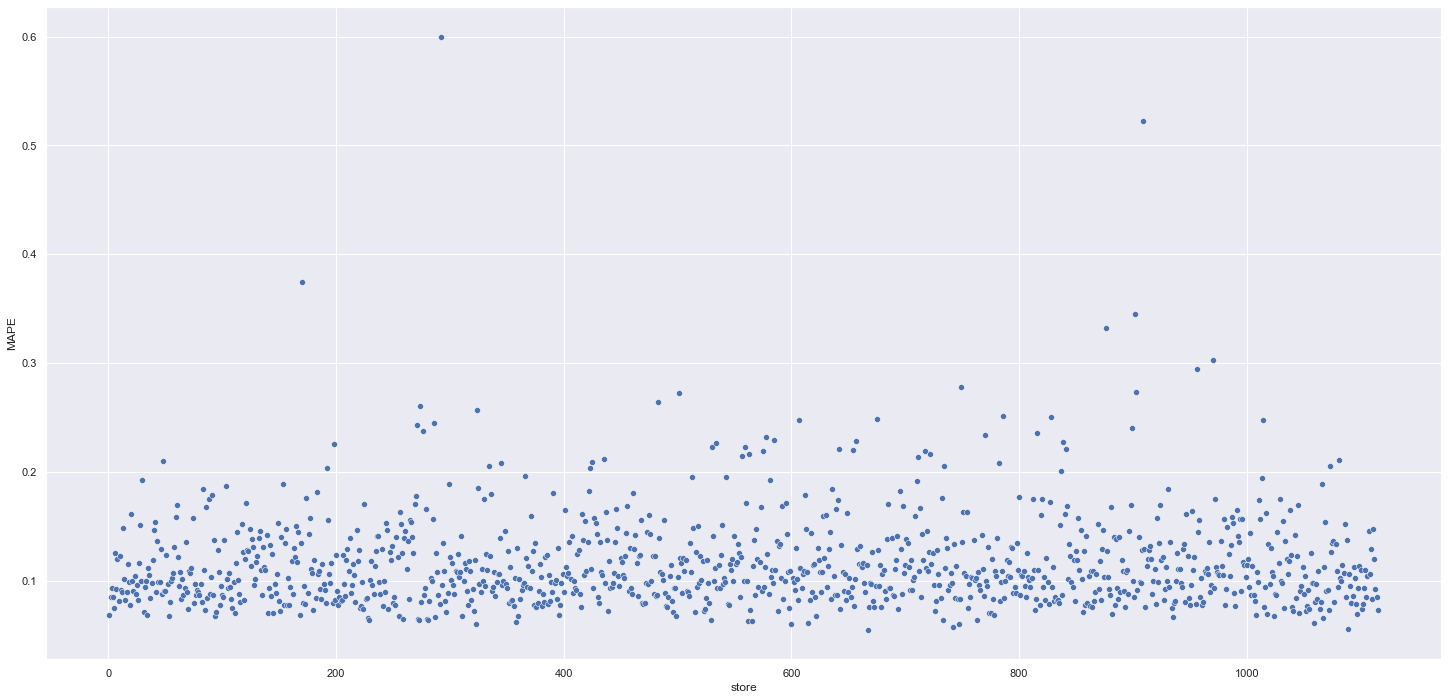

In [96]:
sns.scatterplot(x = 'store', y = 'MAPE', data = df92)

In [97]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1087,1088,194764.234375,167194.388975,222334.079775,656.424890,0.137616
531,532,400096.156250,354415.642420,445776.670080,1087.631282,0.099995
579,580,359924.437500,324432.738123,395416.136877,845.040461,0.087799
261,262,811326.125000,709933.197402,912719.052598,2414.117324,0.110198


## 9.2 Total Performace

In [98]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index':'Scenario',0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 286,056,384.00"
1,worst_scenario,"R$ 249,905,028.78"
2,best_scenario,"R$ 322,207,795.17"


## 9.3 Machine Learning Performace

In [99]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

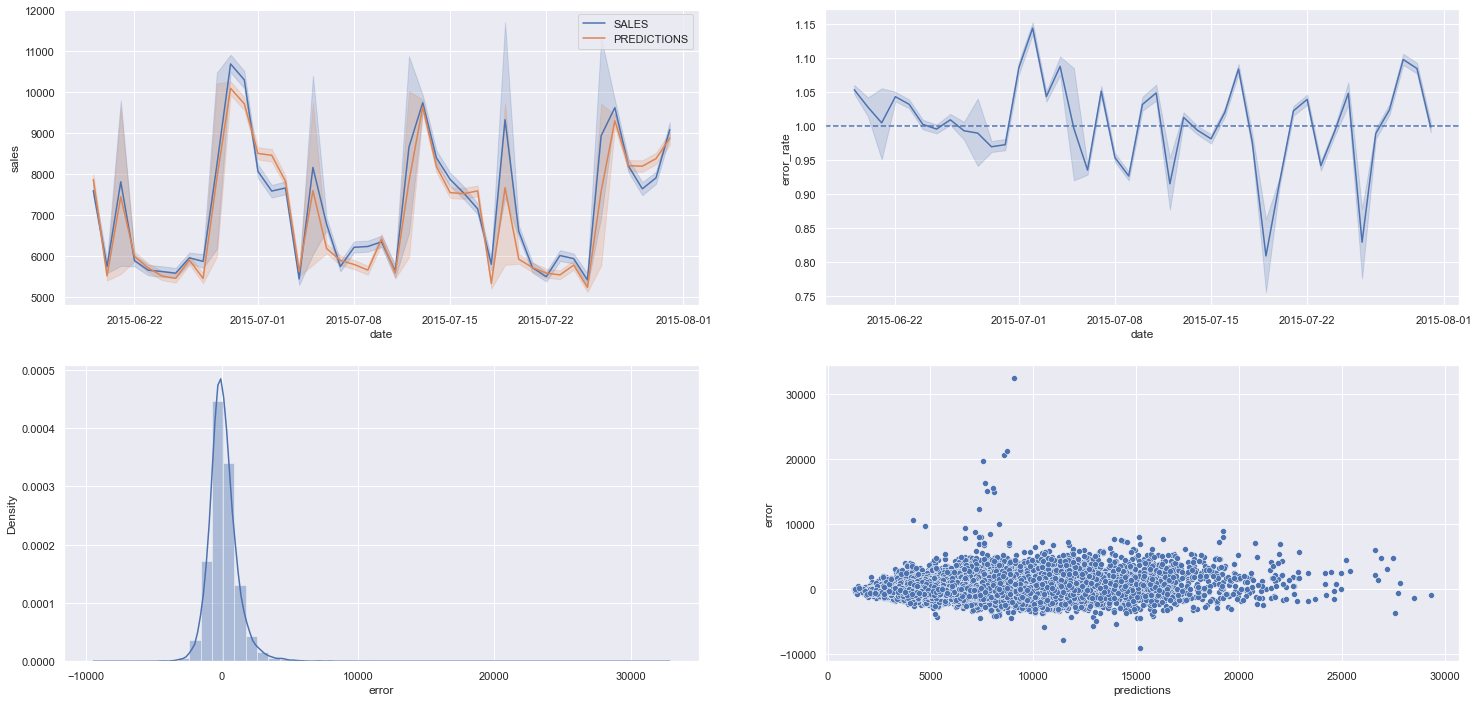

In [100]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label = 'SALES')
sns.lineplot(x='date', y='predictions', data=df9, label = 'PREDICTIONS')


plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'] ,df9['error'])

# 10.0 DEPLOY MODEL TO PRODUCTION

In [101]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open (r"C:\Users\prese\Desktop\Data Scince\Projetos\RossmannStoreSales\model\model_rossmann.pkl",'wb'))

## 10.1 Rossmann Class

In [102]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:\\Users\\prese\\Desktop\\Data Scince\\Projetos\\RossmannStoreSales\\'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        ## 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list( map(snakecase, cols_old)) 

        #rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1["date"] = pd.to_datetime(df1["date"])

        #competition_distance: hipotese, n tem competidor proximo, botaremos distancia mt grande
        df1["competition_distance"] = df1["competition_distance"].apply( lambda x:  200000.0 if math.isnan(x) else x)

        #competition_open_since_month: hipotese, se n sabe e pq faz mt tempo, logo vendas estabilizadas, substitui pela data presente    
        df1["competition_open_since_month"] = df1.apply( lambda x:  x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

        #competition_open_since_year 
        df1["competition_open_since_year"] = df1.apply( lambda x:  x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis = 1)

        #promo2_since_week: hipotese, se NA, então nao participou da promo2, substituir NA pela data para zerar delta   
        df1["promo2_since_week"] = df1.apply( lambda x:  x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis = 1)

        #promo2_since_year 
        df1["promo2_since_year"] = df1.apply( lambda x:  x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis = 1)

        #promo_interval
        month_map = {1: "Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
        df1["promo_interval"].fillna(0, inplace = True)
        df1["month_map"] = df1["date"].dt.month.map(month_map)
        df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)

        ## 1.6 Change Types
        df1["competition_open_since_month"] = df1["competition_open_since_month"].astype("int64")
        df1["competition_open_since_year"] = df1["competition_open_since_year"].astype("int64")
        df1["promo2_since_week"] = df1["promo2_since_week"].astype("int64")
        df1["promo2_since_year"] = df1["promo2_since_year"].astype("int64")
                 
        return df1
    
    
    def feature_engineering(self, df2):

        # year
        df2["year"] = df2["date"].dt.year

        # month
        df2["month"] = df2["date"].dt.month

        # day
        df2["day"] = df2["date"].dt.day

        # week of year
        df2["week_of_year"] = df2["date"].dt.weekofyear

        # year week
        df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

        # competition since
        df2["competition_since"] = df2.apply (lambda x: datetime.datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis = 1)
        df2["competition_time_month"] = ((df2["date"] - df2["competition_since"])/30).apply(lambda x: x.days).astype("int64")

        # promo since
        df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
        df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w") - datetime.timedelta(days=7))
        df2["promo_time_week"] = ((df2['date'] - df2["promo_since"])/7).apply(lambda x: x.days).astype("int64")

        # assortment
        df2["assortment"] = df2["assortment"].apply( lambda x: "basic" if x=='a' else "extra" if x=='b' else "extended")

        # state holiday
        df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday"  if x=='a' else "easter_holiday" if x=='b' else "christmas" if x=='c' else "regular_day") 

        # 3.0 FILTRAGEM DE VARIÁVEIS
        ## 3.1 Filtragem das linhas
        df2 = df2[df2 ["open"] != 0]

        ## 3.2 selecao das colunas
        cols_drop = ["open", "promo_interval", "month_map"]
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
 
        ## 5.2 Rescaling
        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### 5.3.1 Encoding
        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment - Ordinal Encoding
        assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation
        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original date
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2 API Handler

In [103]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open(r'C:\Users\prese\Desktop\Data Scince\Projetos\RossmannStoreSales\model\model_rossmann.pkl','rb'))

#Initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict):  #Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: 
            #Multiple Examples
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
    
        # Instantiate Rossmann class
        pipeline = Rossmann() # creating an Rossmann class object
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run('127.0.0.1')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [104]:
import requests
import json

In [105]:
#lading test dataset
df10 = pd.read_csv(r'C:\Users\prese\Desktop\Data Scince\Projetos\RossmannStoreSales\data\test.csv')

In [106]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([22, 12, 14])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)



In [107]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [111]:
# API Call

#local (python handler.py)
url = 'http://127.0.0.1:5000/rossmann/predict'

#heroku
#url = 'https://yuri-rossmann-model.herokuapp.com/rossman/predict'

header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [112]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [113]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 12 will sell R$ 255,085.58 in the next 6 weeks
Store Number 14 will sell R$ 211,407.93 in the next 6 weeks
Store Number 22 will sell R$ 140,915.95 in the next 6 weeks
